<a href="https://colab.research.google.com/github/khanfs/AI-Research/blob/main/GNN_Predict_Molecule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Graph Neural Network: Molecular Property Predicton**

Graph Neural Network (GNN) constructed to predict the solvation-free energy (expt) of small organic molecules using their chemical structures in SMILES format. The GNN model is based on AttentiveFP, a message-passing neural network (MPNN) that can incorporate attention mechanisms for molecule representation learning. 

The training data is loaded from a CSV file containing the SMILES and expt values of a set of molecules. The dataset is split into three parts for training, validation, and testing, respectively, using a scaffold splitter function. The model is trained using the Smooth L1 loss function and the Adam optimizer, with the R^2 metric used for evaluating the model performance on the validation and test sets. The final test R^2 value is reported at the end of the script. The code uses several Python libraries, including RDKit, DGL, and PyTorch.

In [1]:
! pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **DGL-LifeSci** 
Python [package](lifesci.dgl.ai/index.html) for applying graph neural networks to various tasks in chemistry and biology, on top of PyTorch, DGL, and RDKit. It covers various applications, including:

* Molecular property prediction
* Generative models
* Reaction prediction
* Protein-ligand binding affinity prediction

In [3]:
! pip install dgllife

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import torch
import torch.nn as nn

In [7]:
from torch.utils.data import DataLoader

In [10]:
from dgllife.utils import MolToBigraph

# **1. Graph Construction**

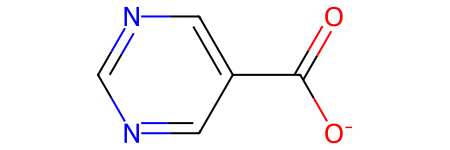

In [11]:
# import RDKIT and rdkit.Chem.Draw
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

# set IPythonConsole.ipython_useSVG to True, which enables SVG-based molecular drawing in Jupyter notebooks
IPythonConsole.ipython_useSVG = True
smiles = 'c1ncncc1C(=O)[O-]'
mol = Chem.MolFromSmiles('c1ncncc1C(=O)[O-]')
mol

In [12]:
# imports the function MolToBigraph from the dgllife.utils module, which is used to convert a molecule object (represented by mol) into a DGLGraph object
from dgllife.utils import MolToBigraph

mol_to_g = MolToBigraph() # creates an instance of the MolToBigraph class, which is used to convert a molecule object to a DGLGraph object
g = mol_to_g(mol) # uses the MolToBigraph instance to convert the mol object to a DGLGraph object, and assigns it to the variable g
print(g)
assert g.num_nodes() == mol.GetNumAtoms() # checks that the number of nodes in g is equal to the number of atoms in the original mol object
assert g.num_edges() == 2 * mol.GetNumBonds() # checks that the number of edges in g is equal to twice the number of bonds in the original mol object

Graph(num_nodes=9, num_edges=18,
      ndata_schemes={}
      edata_schemes={})


# **2. Featurization**

**Extract mode and edge features from the molecular graph, which are inputs for the Graph Neural Network (GNN)**: 

* **Node features (atomic properties)**: atom type, atomic number, formal charge, hybridization state, aromaticity, chirality, number of bonded neighbors, degree of unsaturation.


* **Edge features (bond types)**: single, double, triple, aromatic etc.; stereochemistry (cis/trans or E/Z); conjugation or delocalization; bond length or distance; bond angle or torsion.

The featurizer uses **attention mechanisms to learn the different weights** for different atoms and substructures and the different weights for different bonds and substructures, which helps to capture the most relevant information for predicting the molecular property of interest.

In [13]:
# defines a function called atom_mass that takes an RDKit atom instance as input and returns list containing atom's mass
# mass of the atom is obtained using the GetMass method of the RDKit atom instance, which returns the mass in atomic mass units (amu)
# mass is then multiplied by 0.01 to convert it to kilograms (kg), which is a more commonly used unit of mass in chemistry
def atom_mass(atom): 
    """
    atom: RDKit atom instance 
    """
    return [atom.GetMass() * 0.01] # returns a list containing the mass of the atom, converted to kilograms

atom = mol.GetAtomWithIdx(0) # gets the first atom in the mol object (which is assumed to be an RDKit molecule instance) and assigns it to the variable atom
print(atom_mass(atom)) # calls atom_mass function with atom variable as input, and prints resulting list containing the mass of the atom in kilograms

[0.12011]


**ConcatFeaturizer**: concatenates multiple functions that extract features from RDKit atom instances. Functions are applied to each atom in a molecule to generate a feature vector for each atom. The resulting feature vector is a concatenation of the outputs of all the functions in the list, and contains information about various properties of the atom. 

For example, if the input list contains functions to extract the mass, formal charge, and hybridization state of each atom, the resulting feature vector for each atom would contain information about all three of these properties. ConcatFeaturizer class is useful for generating feature vectors that can be used as input to machine learning models for tasks such as molecular property prediction and drug discovery. It allows for easy customization of the feature extraction process by enabling.

**atom_formal_charge**: a function used to extract the formal charge of an RDKit atom instance. The formal charge of an atom is the difference between the number of valence electrons on the atom and the number of electrons that it actually has in its bonded state. A positive formal charge means the atom has lost electrons, while a negative formal charge means the atom has gained electrons.

The atom_formal_charge function takes an RDKit atom instance as input and returns the formal charge of the atom as an integer. If the atom does not have a formal charge, the function returns 0.

The formal charge of an atom can be an important feature for predicting molecular properties such as reactivity and stability. It can also be used to identify and classify different types of atoms in a molecule based on their electronic properties.

In [14]:
from dgllife.utils import ConcatFeaturizer, atom_formal_charge

atom_featurizer = ConcatFeaturizer([atom_mass, atom_formal_charge])
print(atom_featurizer(atom))

[0.12011, 0]


**BaseAtomFeaturizer**: Used to generate feature vectors for individual atoms in a molecule. Feature vectors used as input to machine learning models for tasks such as molecular property prediction and drug discovery. It enables customization of the feature extraction process by allowing the use of different feature extraction functions for different types of information about each atom in the molecule.

In [15]:
from dgllife.utils import BaseAtomFeaturizer

mol_atom_featurizer = BaseAtomFeaturizer({'feat': atom_featurizer})
print('feat size:', mol_atom_featurizer.feat_size())
print(mol_atom_featurizer(mol))

feat size: 2
{'feat': tensor([[ 0.1201,  0.0000],
        [ 0.1401,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1401,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1600,  0.0000],
        [ 0.1600, -1.0000]])}


# **3. Data Preprocessing**
**FreeSolv Dataset**: Dataset contains experimental and calculated hydration free energies for small molecules, and is commonly used as a benchmark dataset for molecular property prediction tasks.

In [16]:
from dgl.data.utils import download, _get_dgl_url, extract_archive 

# Download dataset "FreeSolv" and extracts its contents into a directory called "FreeSolv"
url = 'dataset/FreeSolv.zip'
data_path = 'FreeSolv.zip'
download(_get_dgl_url(url), path=data_path)
extract_archive(data_path, './FreeSolv')

Extracting file to ./FreeSolv


In [17]:
import pandas as pd

df = pd.read_csv('FreeSolv/SAMPL.csv')
df.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


**MoleculeCSVDataset**: used to create a dataset of molecules represented as DGL graphs, where each graph corresponds to a molecule in the input CSV file. CSV file contains information about molecules, such as their SMILES strings and experimental properties, and converts each molecule into a DGL graph. The class allows you to specify how to featurize each node and edge in the graph using different featurization methods, such as molecular fingerprints or neural network-based featurization. 

**AttentiveFPAtomFeaturizer**: a neural network-based featurization method used to encode the features of atoms in a molecular graph. The AttentiveFP method uses a neural network to learn the atom features from its local substructure, along with the features of its neighboring atoms and edges. The method incorporates attention mechanisms to learn different weights for different atoms and substructures, which helps to capture the most relevant information for predicting the molecular property of interest. The AttentiveFPAtomFeaturizer class takes as input a molecular graph represented as a DGLGraph object, and returns a tensor of learned atom features, where each row of the tensor corresponds to the features of one atom in the graph.

**AttentiveFPBondFeaturizer**: extracts a set of features for each bond in the graph; a neural network-based featurization method used to encode the features of bonds in a molecular graph; neural network learns the bond features from its local substructure, along with the features of its neighboring atoms and other bonds. The method incorporates attention mechanisms to learn different weights for different bonds and substructures, which helps to capture the most relevant information for predicting the molecular property of interest. Takes as input a molecular graph represented as a DGLGraph object, and returns a tensor of learned bond features, where each row of the tensor corresponds to the features of one bond in the graph.

In [18]:
from dgllife.data import MoleculeCSVDataset
from dgllife.utils import AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer

# define the featurizers used to extract features from the nodes and edges of molecular graphs

node_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='feat') # extracts features for each atom, argument atom_data_field='feat' specifies that the features for each atom are stored in the feat field of the node data dictionary
edge_featurizer = AttentiveFPBondFeaturizer(bond_data_field='feat') # extracts features for each bond, bond_data_field='feat' specifies that the features for each bond are stored in the feat field of the edge data dictionary

# dataset:
# creates a MoleculeCSVDataset object, which reads in molecular data from a CSV file (df) and prepares it for use in model
# node_featurizer and edge_featurizer are used to extract features from each atom and bond in the molecules
# argument smiles_column='smiles' specifies that the SMILES strings for each molecule are stored in the smiles column of the CSV file
# task_names=['expt'] specifies the name of the property to predict for each molecule, which is expt
# cache_file_path='dglgraph.bin' specifies the path where the preprocessed data will be stored to speed up future data loading.

dataset = MoleculeCSVDataset(df, 
                             node_featurizer=node_featurizer,
                             edge_featurizer=edge_featurizer,
                             smiles_column='smiles',
                             task_names=['expt'],
                             cache_file_path='dglgraph.bin')
print('dataset size:', len(dataset)) # print out the size of the dataset and the first example in the dataset, respectively
print(dataset[0])

Processing dgl graphs from scratch...
dataset size: 642
('CN(C)C(=O)c1ccc(cc1)OC', Graph(num_nodes=13, num_edges=26,
      ndata_schemes={'feat': Scheme(shape=(39,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(10,), dtype=torch.float32)}), tensor([-11.0100]), tensor([1.]))


# **4. Model Training**

**ScaffoldSplitter**: method for splitting a molecular dataset into training, validation, and test sets while preserving the structural diversity of the molecules in each set. The basic idea behind this method is to group structurally similar molecules into the same set so that the model can be trained, validated, and tested on a diverse set of molecules. This method first identifies the molecular scaffold of each molecule and then splits the dataset based on the scaffolds, such that each scaffold appears in only one of the training, validation, or test sets. This ensures that the model is not overfitting to a particular set of molecules with similar scaffolds, but rather generalizes well to a diverse range of molecules. ScaffoldSplitter is commonly used in molecular machine learning for tasks such as molecular property prediction and molecular generation.

In [19]:
# split dataset into training, validation, and test sets based on scaffold structures of molecules
from dgllife.utils import ScaffoldSplitter

train_set, val_set, test_set = ScaffoldSplitter.train_val_test_split( # training set 
    dataset, frac_train=0.8, frac_val=0.1, # training set will contain 80% of the data, validation set will contain 10%
    frac_test=0.1, scaffold_func='smiles') # test set will contain 10% of the data

Start initializing RDKit molecule instances...
Start computing Bemis-Murcko scaffolds.


In [20]:
# defines a function collate_molgraphs that takes in molecular graph list and labels and returns a batch of these graphs with labels
# zip() groups the data samples together by their corresponding smiles, graphs, labels and masks
# map() applies the list() function to each group of data, effectively unpacking the data samples from their original structure

def collate_molgraphs(data):
    smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs) # batch the graphs together into a single big graph (bg)
    labels = torch.stack(labels, dim=0) # stacks the labels tensors along the 0th dimension to form a single tensor
    masks = torch.stack(masks, dim=0) # stacks the masks tensors along the 0th dimension to form a single tensor

    return smiles, bg, labels, masks # returns the smiles, bg, labels, and masks tensors packed into a tuple

# DataLoader will create batches of 128 samples each during training
# batch is a subset of the entire dataset used for training the machine learning model; is a way of dividing the entire dataset into smaller parts to fit into the memory during training
# by using batches, the model can update the parameters after each batch instead of after each individual data point, which makes the training process more efficient
# large batch size means faster training, but requires more memory, can sometimes result in less accurate model updates due to noisy gradients
# batch size requires some experimentation to find the right balance between training speed and accuracy

batch_size = 128 # during training, the model will receive and process 128 samples in parallel
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, 
                          shuffle=True, collate_fn=collate_molgraphs)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size,
                        collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size,
                         collate_fn=collate_molgraphs)

**AttentiveFPPredictor**: neural network model used for predicting molecular properties. It is part of the DGL-LifeSci package, which provides various deep learning tools for drug discovery and molecular generation tasks. The AttentiveFPPredictor model is based on the AttentiveFP approach, which combines message passing neural networks (MPNNs) with attention mechanisms to generate molecular representations that are sensitive to the relevant substructures for predicting molecular properties.

**Message Passing Neural Networks (MPNNs)** class of neural networks that are designed to operate on graph-structured data. MPNNs perform computation by passing messages between the nodes of the graph. At each layer of the MPNN, the node features are updated based on the messages that have been received from neighboring nodes in the previous layer. MPNNs are composed of two main components: a message function and a readout function. 

The message function is responsible for computing the messages that are passed between nodes, while the readout function aggregates the node features to produce a graph-level representation. MPNNs have been applied to a wide range of tasks, including molecule property prediction, protein-ligand binding affinity prediction, and materials design. They are a powerful tool for modeling complex systems that can be represented as graphs.

**AttentiveFP**: extension of the Message Passing Neural Networks (MPNNs) approach for molecular property prediction. The AttentiveFP approach combines message passing with an attention mechanism to allow the model to focus on specific atoms and bonds that are important for predicting the target property.

In AttentiveFP, each atom and bond is assigned a learnable attention weight. During the message passing process, these attention weights are used to compute a weighted sum of the messages received by each atom and bond. This weighted sum is then used to update the atom or bond state. The attention weights are learned through a separate neural network called the AttentiveFP Predictor, which takes as input the features of the atom or bond and outputs a scalar attention weight. By training the AttentiveFP Predictor together with the main model for the property prediction task, the attention weights are learned to focus on the parts of the molecule that are most relevant for the task.

**Adaptive Moment Estimation (Adam)**: Adam is an optimization algorithm used for stochastic gradient descent. It is an extension of the traditional gradient descent algorithm that is designed to converge faster and more reliably to the optimal weights for a neural network. *Adam calculates the learning rate for each weight in a neural network*, based on the history of gradients for that weight. The learning rate is adjusted dynamically as the training progresses, leading to faster convergence and better performance. Adam is a popular optimizer in deep learning, particularly for large-scale models with many parameters.

**SmoothL1Loss**: type of loss function commonly used in deep learning for regression tasks. It is similar to the Mean Squared Error (MSE) loss function, but it is less sensitive to outliers. The SmoothL1Loss function calculates the difference between the predicted and target values, and applies a smoothing function if the absolute difference is below a certain threshold. The smoothing function is typically a quadratic function for small errors and a linear function for larger errors. The resulting loss value is the mean of the smoothed errors. The SmoothL1Loss function is also known as the Huber loss function.

In [21]:
import torch.nn as nn
from dgllife.model import AttentiveFPPredictor
from torch.optim import Adam

# node_feat_size and edge_feat_size parameters specify the size of the node and edge features used by the model, respectively
# sizes are obtained from the node_featurizer and edge_featurizer objects created earlier
# n_tasks parameter specifies the number of prediction tasks for the model, which is 1
# AttentiveFPBondFeaturizer extracts the bond type (encoded as a one-hot vector) and the distance between the atoms (scaled by a factor of 10)
# therefore, the edge feature size is 7 (one-hot encoding of bond type) plus 1 (scaled bond distance), which equals 8

model = AttentiveFPPredictor(
    node_feat_size=node_featurizer.feat_size(),
    edge_feat_size=edge_featurizer.feat_size(),
    n_tasks=dataset.n_tasks
)
loss_criterion = nn.SmoothL1Loss(reduction='none') # reduction='none' argument means that the loss is not averaged or summed over the batch
optimizer = Adam(model.parameters(), lr=3e-4) # update the parameters of the model during training; the lr=3e-4 argument specifies learning rate used by optimizer

**Meter**: a class from the dgllife.utils module that provides an interface for tracking the performance metrics of a machine learning model. The Meter class provides several methods for updating and computing various evaluation metrics, such as mean absolute error, root mean squared error, and R2 score. The import Meter statement in the code allows the code to use the Meter class to track and report the performance metrics of the GNN model during training and evaluation.

**epoch**: an epoch is a complete pass through a dataset during training of a machine learning model. In other words, an epoch is the number of times the model has seen the entire training dataset. During each epoch, the model iteratively updates its weights based on the input data and the corresponding labels. Typically, the number of epochs is decided based on the size and complexity of the dataset and the training algorithm being used. One epoch can consist of multiple iterations or batches, where each batch is a small subset of the training dataset.

**R2 score**: also known as the coefficient of determination, is a statistical measure that represents the proportion of variance in the target variable (i.e., the dependent variable) that can be explained by the input variables (i.e., the independent variables) in a regression model.

In the context of machine learning, R2 score is often used as an evaluation metric to measure how well a model can predict the target variable. It ranges from 0 to 1, where a score of 1 indicates that the model can perfectly predict the target variable, and a score of 0 indicates that the model's predictions are no better than the mean of the target variable. Negative scores can also occur if the model's predictions are worse than the mean of the target variable.

In the code, the r2 metric is computed using the Meter class to evaluate the performance of the GNN model during training and evaluation. The r2 metric measures how well the GNN model can predict the target variable (i.e., labels) compared to the ground truth, and it is reported as a floating-point number between 0 and 1.

**In this code, the target variable is the solvation free energy (expt) and the dependent variable is the molecular structure of the compounds represented by SMILES strings. The goal is to predict the solvation free energy of new compounds given their molecular structures**.

In [22]:
import dgl
import numpy as np
from dgllife.utils import Meter

# defines a function named run_a_train_epoch that takes in four parameters: model, data_loader, loss_criterion, and optimizer

def run_a_train_epoch(model, data_loader, loss_criterion, optimizer): 
    model.train() # sets the model to training mode
    train_meter = Meter() # creates a new Meter object to track the training metrics
    for _, batch_data in enumerate(data_loader): # iterates over each batch of data in the data loader
        smiles, bg, labels, masks = batch_data # unpacks the batch data into four variables: list smile stringes, batch molecular graphs, labels and masks
        if len(smiles) == 1: # checks if the batch size is 1. If so, the batch is skipped to avoid potential issues with batch normalization
            # Avoid potential issues with batch normalization
            continue
        
        pred = model(bg, bg.ndata['feat'], bg.edata['feat']) # computes model's predictions for batch using the input graph bg and the node and edge features
        loss = (loss_criterion(pred, labels) * (masks != 0).float()).mean() # omputes the loss for the batch using the specified loss criterion and masks out any padded elements in the labels tensor
        optimizer.zero_grad() # clears the gradients of all optimized tensors
        loss.backward() # computes the gradients of the loss with respect to the model parameters
        optimizer.step() # updates the model parameters using the computed gradients
        train_meter.update(pred, labels, masks) # object with the current batch's performance metrics
    return np.mean(train_meter.compute_metric('r2')) # computes the mean R2 score for the entire training set using the train_meter object and returns it

# defines a function named run_an_eval_epoch that takes two arguments, model and data_loader
# switches the model to evaluation mode, where layers like dropout or batch normalization are turned off
# this ensures that the model is not affected by regularization during evaluation

def run_an_eval_epoch(model, data_loader):
    model.eval() 
    eval_meter = Meter() # initializes an instance of a Meter class, which is used to keep track of evaluation metrics like R-squared or mean squared error
    for _, batch_data in enumerate(data_loader): # loops through each batch of data in data_loader and unpacks the batch into four variables smiles, bg, labels, and masks
        smiles, bg, labels, masks = batch_data 
        pred = model(bg, bg.ndata['feat'], bg.edata['feat']) # computes predictions for the batch by calling the model function with three arguments:
        # bg is the DGLGraph object representing the molecular graphs in the batch
        # bg.ndata['feat'] is a tensor of node features for each graph node
        # bg.edata['feat'] is a tensor of edge features for each graph edge
        # pred is a tensor of predicted values for each molecule in the batch
        eval_meter.update(pred, labels, masks) # updates the eval_meter object with the predicted values, target values, and masks for the current batch
    return np.mean(eval_meter.compute_metric('r2')) # computes the R-squared metric for the entire evaluation set using the compute_metric method of the eval_meter object

# this block of code trains the model for 100 epochs and prints the training and validation R-squared scores after each epoch
# train_r2 is computed by calling the run_a_train_epoch function, which trains the model on the training set for one epoch
# val_r2 is computed by calling the run_an_eval_epoch function, which evaluates the model on the validation set
# print statement outputs the current epoch number, training R-squared score, and validation R-squared score

for epoch in range(100):
    train_r2 = run_a_train_epoch(model, train_loader, loss_criterion, optimizer)
    val_r2 = run_an_eval_epoch(model, val_loader)
    print('epoch {:d} | train r2 {:.4f} | val r2 {:.4f}'.format(epoch, train_r2, val_r2))
test_r2 = run_an_eval_epoch(model, test_loader) # evaluates the trained model on the test set and computes the R-squared score using the run_an_eval_epoch function
print('test r2 {:.4f}'.format(test_r2)) # prints the R-squared score for the test set

epoch 0 | train r2 0.0489 | val r2 0.0459
epoch 1 | train r2 0.0883 | val r2 0.0467
epoch 2 | train r2 0.1147 | val r2 0.0497
epoch 3 | train r2 0.1256 | val r2 0.0561
epoch 4 | train r2 0.1550 | val r2 0.0633
epoch 5 | train r2 0.1505 | val r2 0.0694
epoch 6 | train r2 0.1746 | val r2 0.0774
epoch 7 | train r2 0.1861 | val r2 0.0870
epoch 8 | train r2 0.1981 | val r2 0.0972
epoch 9 | train r2 0.2091 | val r2 0.1069
epoch 10 | train r2 0.2164 | val r2 0.1165
epoch 11 | train r2 0.2262 | val r2 0.1263
epoch 12 | train r2 0.2365 | val r2 0.1353
epoch 13 | train r2 0.2482 | val r2 0.1489
epoch 14 | train r2 0.2609 | val r2 0.1645
epoch 15 | train r2 0.2725 | val r2 0.1808
epoch 16 | train r2 0.2913 | val r2 0.2008
epoch 17 | train r2 0.3101 | val r2 0.2252
epoch 18 | train r2 0.3370 | val r2 0.2558
epoch 19 | train r2 0.3715 | val r2 0.2942
epoch 20 | train r2 0.4083 | val r2 0.3420
epoch 21 | train r2 0.4575 | val r2 0.4089
epoch 22 | train r2 0.5049 | val r2 0.4981
epoch 23 | train r2 0

In [23]:
! pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Colours indicate the attention weights assigned to each atom in the molecular graph by the [Graph Attention Network](https://arxiv.org/abs/1710.10903) (GAT) model. The attention weights provide information about how important each atom is for predicting the solvation free energy (expt column) of small molecules. 

The range of colors indicates the values of the predicted free energy in kcal/mol, with higher values being represented by darker colors. The code normalizes the attention weights and maps them to an orange color scale using the ScalarMappable function from the matplotlib library. The color intensity of each atom in the 2D visualization of the molecule is then proportional to its attention weight.

Orange is the color used to represent the highest value in the range. The color range is determined by the cmap variable, which is defined using cm.get_cmap('Oranges'). This colormap goes from light yellow to dark orange, with increasing values. The atom with the highest value in atom_weights is colored in the darkest shade of orange, while the atom with the lowest value is colored in the lightest shade of yellow.

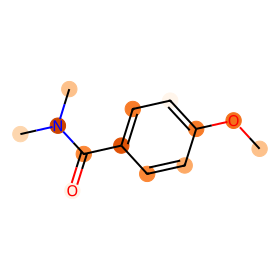

In [24]:
# visualise the attention weights of the graph neural network on the molecule
import matplotlib
import matplotlib.cm as cm

from IPython.display import SVG, display # SVG and display module are used to display the molecule visualization in Jupyter notebook
from rdkit.Chem import rdDepictor # module used to generate 2D coordinates for the molecule
from rdkit.Chem.Draw import rdMolDraw2D # module used to draw the molecule

smiles, g, _, _ = dataset[0] # retrieves the SMILES representation, graph object g, and other variables from the first molecule in the dataset
_, atom_weights = model(g, g.ndata['feat'], g.edata['feat'], get_node_weight=True) # computes the attention weights for each atom in the molecule using the model object i.e. GNN
# get_node_weight=True argument specifies that the weights should be returned
# atom_weights is a list of length 2
# we use the second suite of atom weights for visualization in this demo
atom_weights = atom_weights[-1] # extracts the last set of weights from the atom_weights list

# min-max normalization to make it easier to distinguish attention values
min_value = torch.min(atom_weights) # computes the minimum value of the attention weights
max_value = torch.max(atom_weights) # computes the maximum value of the attention weights
atom_weights = (atom_weights - min_value) / (max_value - min_value) # normalizes the attention weights to make them easier to distinguish by scaling them between 0 and 1

# conver the weights to atom colors
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28)
cmap = cm.get_cmap('Oranges')
plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
# creates a dictionary of atom indices to colors, where the color for each atom is determined by the corresponding attention weight and the plt_colors object
atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) 
               for i in range(g.num_nodes())}

mol = Chem.MolFromSmiles(smiles) # constructs a molecule object from the SMILES representation
rdDepictor.Compute2DCoords(mol) # computes 2D coordinates for the molecule using the rdDepictor module
drawer = rdMolDraw2D.MolDraw2DSVG(280,280) # creates a MolDraw2DSVG object from the rdMolDraw2D module with a canvas size of 280x280 pixels
drawer.SetFontSize(1)
op = drawer.drawOptions()
    
mol = rdMolDraw2D.PrepareMolForDrawing(mol) # prepares the molecule mol for drawing by setting up coordinates for each atom and bond in the molecule using the rdDepictor module

# draws the molecule using the rdMolDraw2D module, with the highlightAtoms argument set to a list of all the atoms in the molecule (specified using the range function and the num_nodes attribute of the g object)
# the highlightBonds argument set to an empty list (indicating that no bonds should be highlighted)
# the highlightAtomColors argument set to the dictionary atom_colors, which contains the colors to use for highlighting each atom based on the attention weights

drawer.DrawMolecule(mol, highlightAtoms=range(g.num_nodes()),highlightBonds=[],
                    highlightAtomColors=atom_colors)
drawer.FinishDrawing() # finalizes the drawing of the molecule, indicating that no more elements will be added to the drawing
svg = drawer.GetDrawingText() # retrieves the SVG representation of the molecule drawing as a string
svg = svg.replace('svg:','') # replaces the namespace prefix svg: in the SVG string with an empty string, to make the SVG compatible with displaying in a Jupyter notebook
display(SVG(svg)) # displays the SVG image in the notebook using the IPython.display module